Modification of NuScenes Qualitative.ipynb file to inspect and plot Trajectron latent variables.

In [22]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
NCOLORS = len(AGENT_COLORS)

In [23]:
# Load nuScenes SDK
nuScenes_data_path = "/home/fireofearth/code/robotics/trajectron-plus-plus/experiments/nuScenes/v1.0"
# Data Path to nuScenes data set
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [24]:
# Load dataset
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [25]:
# Load model
ph = 6
log_dir = './models'
model_dir = os.path.join(log_dir, 'int_ee_me')
eval_stg, hyp = load_model(
    model_dir, eval_env, ts=12)


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



In [26]:
# looking at Torch API
a = torch.randint(10, (3, 3))
b = torch.randint(10, (3, 3))
print(a)
print(b)
c = torch.cat([a[None], b[None]], 0)
print(c)
torch.argmax(c, 2)

tensor([[2, 7, 6],
        [9, 5, 5],
        [3, 2, 1]])
tensor([[5, 8, 8],
        [9, 7, 5],
        [8, 2, 6]])
tensor([[[2, 7, 6],
         [9, 5, 5],
         [3, 2, 1]],

        [[5, 8, 8],
         [9, 7, 5],
         [8, 2, 6]]])


tensor([[1, 0, 0],
        [2, 0, 0]])

scene 105
[VEHICLE/ego, VEHICLE/c1932b698eb445fcba4ceb9db6a38556, VEHICLE/e8b0b33be1a647dc8a329d21188fb849, VEHICLE/2b4cd40aad5547629d6f7dab2b6a247b, VEHICLE/be6935a41c3e47bda91e38baf47543c7, VEHICLE/0b99dd853db1493098d9f28e3306c809]


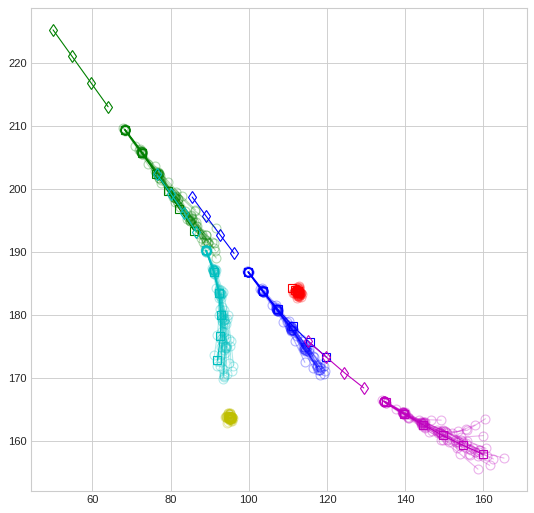

In [54]:
scene = eval_scenes[25]
print("scene", scene.name)
ph = 6
num_samples=18
t = 3
timesteps = np.array([t])

with torch.no_grad():
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=True,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
print(v_nodes)

plt.figure(figsize=(8, 8), dpi=80)
for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    plt.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    plt.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        plt.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS], alpha=0.3,
                linewidth=1, markersize=8, markerfacecolor='none')

plt.show()

Question, when generating `num_samples` $>$ 1 samples from a vehicle, are these samples generated with different z? The answer is yes. Just set no options to true.

Options illustration:
suppose `num_samples` is 12 and scene is `105` (6 vehicles).

Nothing is set to true: z is an array of shape (12, 6, 25).
It seems like 12 refers to the number of samples I want to generate and 6 refers to the number of vehicles.
The ones along the last axis is randomly placed, and random for each run, meaning each sample of each vehicle is drawn from a random z, which is what we want.

Only `z_mode` set to true: z has shape (12, 6, 25). Array is the same for each run, for each sample.
This mode is the same as $z_{\text{mode}}$ setting in the paper.

Only `gmm_mode` is set to true: does not affect selection of z. Only used when sampling the GMM2D.
Not sure what it does.

Only `full_dist` set to true: z is an array of shape (300, 6, 25) where 300 is 12 $\times$ 25.
Seems like we are drawing a sample for every vehicle for every choice of z from 0 to 24.

Only `all_z_sep` is set to true: not sure what this does

In [136]:
# Trajectron.predict() arguments
num_samples = 200
min_future_timesteps = 0
min_history_timesteps = 1
z_mode = False
gmm_mode = False
full_dist = False
all_z_sep = False

node_type = eval_stg.env.NodeType.VEHICLE
if node_type not in eval_stg.pred_state:
    raise Exception("fail")

model = eval_stg.node_models_dict[node_type]

# Get Input data for node type and given timesteps
batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type, state=eval_stg.state,
                           pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                           min_ht=min_history_timesteps, max_ht=eval_stg.max_ht, min_ft=min_future_timesteps,
                           max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
# There are no nodes of type present for timestep
if batch is None:
    raise Exception("fail")

(first_history_index,
 x_t, y_t, x_st_t, y_st_t,
 neighbors_data_st,
 neighbors_edge_value,
 robot_traj_st_t,
 map), nodes, timesteps_o = batch

x = x_t.to(eval_stg.device)
x_st_t = x_st_t.to(eval_stg.device)
if robot_traj_st_t is not None:
    robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
if type(map) == torch.Tensor:
    map = map.to(eval_stg.device)

# MultimodalGenerativeCVAE.predict() arguments
inputs = x
inputs_st = x_st_t
first_history_indices = first_history_index
neighbors = neighbors_data_st
neighbors_edge_value = neighbors_edge_value
robot = robot_traj_st_t
prediction_horizon = ph

mode = ModeKeys.PREDICT

x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                           inputs=inputs,
                                                           inputs_st=inputs_st,
                                                           labels=None,
                                                           labels_st=None,
                                                           first_history_indices=first_history_indices,
                                                           neighbors=neighbors,
                                                           neighbors_edge_value=neighbors_edge_value,
                                                           robot=robot,
                                                           map=map)

model.latent.p_dist = model.p_z_x(mode, x)
z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                      mode,
                                                      most_likely_z=z_mode,
                                                      full_dist=full_dist,
                                                      all_z_sep=all_z_sep)

# after call model.p_y_xz()

# z, z.shape

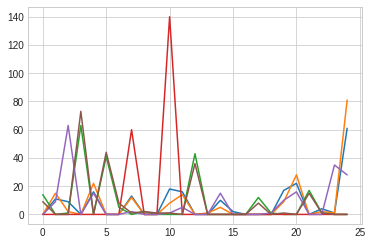

In [137]:
znp = z.detach().numpy()
znp_counts = np.sum(znp, axis=0)
True
# print(znp_counts[:, 10:])

for zz in znp_counts:
    plt.plot(range(25), zz)
plt.show()

Need to make modifications to Scene class to get location of the forecasts with respect to the map.

https://github.com/StanfordASL/Trajectron-plus-plus/issues/18